In [1]:
from google.colab import drive
drive.mount('/content/drive')

! cp '/content/drive/MyDrive/24788-24789/code_q1_template/airfoils.zip' .
! unzip airfoils.zip

Mounted at /content/drive
Archive:  airfoils.zip
   creating: airfoils/
  inflating: airfoils/2032c_clean.dat  
  inflating: airfoils/a18sm_clean.dat  
  inflating: airfoils/a18_clean.dat  
  inflating: airfoils/a63a108c_clean.dat  
  inflating: airfoils/ag03_clean.dat  
  inflating: airfoils/ag04_clean.dat  
  inflating: airfoils/ag08_clean.dat  
  inflating: airfoils/ag09_clean.dat  
  inflating: airfoils/ag10_clean.dat  
  inflating: airfoils/ag11_clean.dat  
  inflating: airfoils/ag12_clean.dat  
  inflating: airfoils/ag13_clean.dat  
  inflating: airfoils/ag14_clean.dat  
  inflating: airfoils/ag16_clean.dat  
  inflating: airfoils/ag17_clean.dat  
  inflating: airfoils/ag18_clean.dat  
  inflating: airfoils/ag19_clean.dat  
  inflating: airfoils/ag24_clean.dat  
  inflating: airfoils/ag25_clean.dat  
  inflating: airfoils/ag26_clean.dat  
  inflating: airfoils/ag27_clean.dat  
  inflating: airfoils/ag35_clean.dat  
  inflating: airfoils/ag36_clean.dat  
  inflating: airfoils/ag37

In [2]:
# dataset.py

import os
import torch
import numpy as np
from torch.utils.data import Dataset


class AirfoilDataset(Dataset):
	'''
	airfoil dataset: no need to modify
	'''
	def __init__(self, path='./airfoils'):
		super(AirfoilDataset, self).__init__()
		self._X = []	# x coordinates of all airfoils (shared)
		self._Y = []	# y coordinates of all airfoils
		self.names = []	# name of all airfoils
		self.norm_coeff = 0	# normalization coeff to scale y to [-1, 1]
		airfoil_fn = [afn for afn in os.listdir(path) if afn.endswith('.dat')]

		# get x coordinates of all airfoils
		with open(os.path.join(path, airfoil_fn[0]), 'r', encoding="utf8", errors='ignore') as f:
			raw_data = f.readlines()
			for idx in range(len(raw_data)):
				raw_xy = raw_data[idx].split(' ')
				while "" in raw_xy:
					raw_xy.remove("")
				self._X.append(float(raw_xy[0]))
		self._X = np.array(self._X)

		# get y coordinates of each airfoils
		for idx, fn in enumerate(airfoil_fn):
			with open(os.path.join(path, fn), 'r', encoding="utf8", errors='ignore') as f:
				self.names.append(fn[:-10])
				raw_data = f.readlines()
				airfoil = np.empty(self._X.shape[0])
				for i in range(len(raw_data)):
					raw_xy = raw_data[i].split(' ')
					while "" in raw_xy:
						raw_xy.remove("")
					curr_y = float(raw_xy[1])
					airfoil[i] = curr_y
					self.norm_coeff = max(self.norm_coeff, np.abs(curr_y))
				self._Y.append(airfoil)

		self._Y = np.array([airfoil / self.norm_coeff for airfoil in self._Y], dtype=np.float32)

	def get_x(self):
		'''
		get shared x coordinates
		'''
		return self._X

	def get_y(self):
		'''
		get y coordinates of all airfoils
		'''
		return self._Y

	def __getitem__(self, idx):
		return self._Y[idx], self.names[idx]
		
	def __len__(self):
		return len(self._Y)



In [3]:
# utils.py

'''
Utility functions 
Free from to add functions if needed
'''

import torch
import matplotlib.pyplot as plt


def plot_airfoils(airfoil_x, airfoil_y):
    '''
    plot airfoils: no need to modify 
    '''
    idx = 0
    fig, ax = plt.subplots(nrows=4, ncols=4)
    for row in ax:
        for col in row:
            col.scatter(airfoil_x, airfoil_y[idx, :], s=0.6, c='black')
            col.axis('off')
            col.axis('equal')
            idx += 1
    plt.show()

In [4]:
# gan.py

import torch
import torch.nn as nn


class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        # build your model here
        # your output should be of dim (batch_size, 1)
        # since discriminator is a binary classifier
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(input_dim)), 512),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # define your feedforward pass
        flat_input = x.view(x.size(0), -1)
        return self.model(flat_input)


class Generator(nn.Module):
    def __init__(self, latent_dim, airfoil_dim):
        super(Generator, self).__init__()
        # build your model here
        # your output should be of dim (batch_size, airfoil_dim)
        # you can use tanh() as the activation for the last layer
        # since y coord of airfoils range from -1 to 1
        self.airfoil_dim = int(airfoil_dim)
    
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.1, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 64, normalize=False),
            *block(64, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(airfoil_dim))),
            nn.Tanh()
        )

    def forward(self, x):
        # define your feedforward pass

        out = self.model(x)
        airfoil = out.view(out.size(0), self.airfoil_dim)
        return airfoil

Discriminator model:
 Discriminator(
  (model): Sequential(
    (0): Linear(in_features=200, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.1, inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.1, inplace=True)
    (6): Linear(in_features=128, out_features=1, bias=True)
    (7): Sigmoid()
  )
)
Generator model:
 Generator(
  (model): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
    (2): Linear(in_features=64, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.1, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats

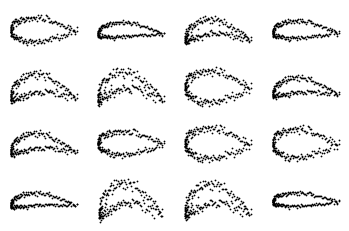

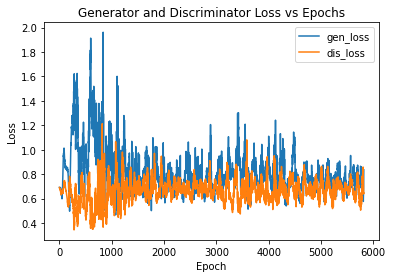

In [5]:
# train_gan.py

'''
train and test GAN model on airfoils
'''

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.optim import Adam
import numpy as np

# from dataset import AirfoilDataset
# from gan import Discriminator, Generator
# from utils import *


def main():
    # check if cuda available
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

    # define dataset and dataloader
    dataset = AirfoilDataset()
    airfoil_x = dataset.get_x()
    airfoil_dim = airfoil_x.shape[0]
    airfoil_dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

    # hyperparameters
    latent_dim = 16 # please do not change latent dimension
    lr_dis = 0.0001 # discriminator learning rate
    lr_gen = 0.0001 # generator learning rate
    num_epochs = 60
    
    # build the model
    dis = Discriminator(input_dim=airfoil_dim).to(device)
    gen = Generator(latent_dim=latent_dim, airfoil_dim=airfoil_dim).to(device)
    print("Discriminator model:\n", dis)
    print("Generator model:\n", gen)

    # define your GAN loss function here
    # you may need to define your own GAN loss function/class
    # loss = ?
    loss = torch.nn.BCELoss()
    # define optimizer for discriminator and generator separately
    optim_dis = Adam(dis.parameters(), lr=lr_dis)
    optim_gen = Adam(gen.parameters(), lr=lr_gen)
    
    dis_loss_list = []
    gen_loss_list = []

    # train the GAN model
    for epoch in range(num_epochs):
        for n_batch, (local_batch, __) in enumerate(airfoil_dataloader):
            y_real = local_batch.to(device)

            valid = Variable(torch.Tensor(local_batch.size(0), 1).fill_(1.0), requires_grad=False)
            fake = Variable(torch.Tensor(local_batch.size(0), 1).fill_(0.0), requires_grad=False)

            # Noise for generator input
            z = Variable(torch.Tensor(np.random.normal(0, 1, (local_batch.shape[0], latent_dim))))

            y_fake = gen(z)
            # train discriminator

            # calculate customized GAN loss for discriminator
            # enc_loss = loss(...)

            optim_dis.zero_grad()

            real_loss = loss(dis(y_real), valid)
            fake_loss = loss(dis(y_fake.detach()), fake)
            loss_dis = (real_loss + fake_loss)/2
            loss_dis.backward()
            optim_dis.step()

            dis_loss_list.append(loss_dis.item())

            # train generator

            # calculate customized GAN loss for generator
            # enc_loss = loss(...)

            optim_gen.zero_grad()

            loss_gen = loss(dis(y_fake), valid)
            loss_gen.backward()
            optim_gen.step()

            gen_loss_list.append(loss_gen.item())

            # print loss while training
            if (n_batch + 1) % 30 == 0:
                print("Epoch: [{}/{}], Batch: {}, Discriminator loss: {}, Generator loss: {}".format(
                    epoch, num_epochs, n_batch, loss_dis.item(), loss_gen.item()))

    # test trained GAN model
    num_samples = 100
    # create random noise 
    noise = torch.randn((num_samples, latent_dim)).to(device)
    # generate airfoils
    gen_airfoils = gen(noise)
    if 'cuda' in device:
        gen_airfoils = gen_airfoils.detach().cpu().numpy()
    else:
        gen_airfoils = gen_airfoils.detach().numpy()

    # plot generated airfoils
    plot_airfoils(airfoil_x, gen_airfoils)


    plt.plot(gen_loss_list, label="gen_loss")
    plt.plot(dis_loss_list, label="dis_loss")
    plt.legend()
    plt.title("Generator and Discriminator Loss vs Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    save_path = './drive/MyDrive/24788-24789/code_q1_template/p1_gan_dis_model.pth'
    torch.save(dis.state_dict(), save_path)
    save_path = './drive/MyDrive/24788-24789/code_q1_template/p1_gan_gen_model.pth'
    torch.save(gen.state_dict(), save_path)
if __name__ == "__main__":
    main()



In [6]:
# vae.py

import torch
import torch.nn as nn


class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        # build your model here
        # your model should output a predicted mean and a predicted std of the encoding
        # both should be of dim (batch_size, latent_dim)
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
        )
        self.mean = nn.Linear(32, latent_dim)
        self.std = nn.Linear(32,latent_dim)

    def forward(self, x):
        # define your feedforward pass
        enc = self.model(x)

        return self.mean(enc), self.std(enc).exp()


class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        # build your model here
        # your output should be of dim (batch_size, output_dim)
        # you can use tanh() as the activation for the last layer
        # since y coord of airfoils range from -1 to 1
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Tanh()
        )
    def forward(self, x):
        # define your feedforward pass
        return self.model(x)


class VAE(nn.Module):
    def __init__(self, airfoil_dim, latent_dim):
        super(VAE, self).__init__()
        self.enc = Encoder(airfoil_dim, latent_dim)
        self.dec = Decoder(latent_dim, airfoil_dim)

    def reparameterize(self, mu, std):
        # std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + std*eps

    def forward(self, x):
        # define your feedforward pass
        mu, std = self.enc(x.view(-1, 200))
        z = self.reparameterize(mu, std)

        return self.dec(z), mu, std

    def decode(self, z):
        # given random noise z, generate airfoils
        return self.dec(z)



VAE model:
 VAE(
  (enc): Encoder(
    (model): Sequential(
      (0): Linear(in_features=200, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=32, bias=True)
      (5): ReLU()
    )
    (mean): Linear(in_features=32, out_features=16, bias=True)
    (std): Linear(in_features=32, out_features=16, bias=True)
  )
  (dec): Decoder(
    (model): Sequential(
      (0): Linear(in_features=16, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=128, bias=True)
      (5): ReLU()
      (6): Linear(in_features=128, out_features=200, bias=True)
      (7): Tanh()
    )
  )
)
Epoch: [0/30], Batch: 29, loss: 1.3400020599365234
Epoch: [0/30], Batch: 59, loss: 0.03232288360595703
Epoch: [0/30], Batch: 89, loss: -2.733518600463867
Epoch: [1/30], Batch: 29, loss

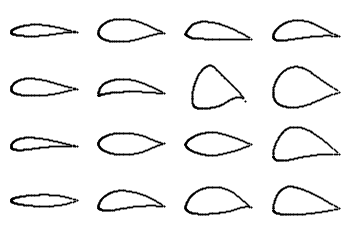

Reconstructed airfoils from originals:


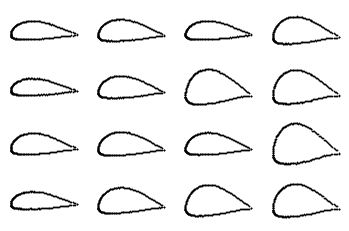

Generated airfoils from noise:


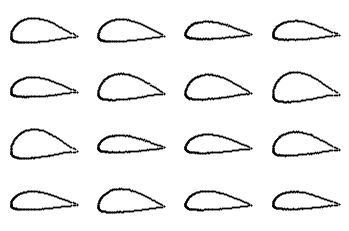

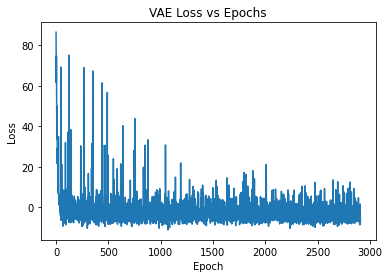

In [7]:
# train_vae.py

'''
train and test VAE model on airfoils
'''

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
import numpy as np
import torch.nn.functional as F

# from dataset import AirfoilDataset
# from vae import VAE
# from utils import *


def main():
    # check if cuda available
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

    # define dataset and dataloader
    dataset = AirfoilDataset()
    airfoil_x = dataset.get_x()
    airfoil_dim = airfoil_x.shape[0]
    airfoil_dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

    # hyperparameters
    latent_dim = 16 # please do not change latent dimension
    lr = 0.001       # learning rate
    num_epochs = 30

    # build the model
    vae = VAE(airfoil_dim=airfoil_dim, latent_dim=latent_dim).to(device)
    print("VAE model:\n", vae)

    # define your loss function here
    # loss = ?

    vae_loss = []

    def loss_function(x, recon_x, mu, std):
      BCE = F.mse_loss(recon_x, x.view(-1, 200), reduction='sum')
      KLD = -0.4 * torch.sum(1 + torch.log(std) - mu**2 - std**2)
      # dist = torch.normal(mu, logvar.exp())
      # norm = torch.randn_like(dist)
      # KLD = F.kl_div(dist, norm)
      return BCE + KLD

    # define optimizer for discriminator and generator separately
    optim = Adam(vae.parameters(), lr=lr, weight_decay=1e-5)
    
    # train the VAE model
    for epoch in range(num_epochs):
        for n_batch, (local_batch, __) in enumerate(airfoil_dataloader):
            y_real = local_batch.to(device)

            # train VAE

            # calculate customized VAE loss
            # loss = your_loss_func(...)

            optim.zero_grad()
            y_recon, mu, std = vae(y_real)

            loss = loss_function(y_real, y_recon, mu, std)

            loss.backward()
            optim.step()

            vae_loss.append(loss.item())
            # print loss while training
            if (n_batch + 1) % 30 == 0:
                print("Epoch: [{}/{}], Batch: {}, loss: {}".format(
                    epoch, num_epochs, n_batch, loss.item()))

    # test trained VAE model
    num_samples = 100

    # reconstuct airfoils
    real_airfoils = dataset.get_y()[:num_samples]
    recon_airfoils, __, __ = vae(torch.from_numpy(real_airfoils).to(device))
    if 'cuda' in device:
        recon_airfoils = recon_airfoils.detach().cpu().numpy()
    else:
        recon_airfoils = recon_airfoils.detach().numpy()
    
    # randomly synthesize airfoils
    noise = torch.randn((num_samples, latent_dim)).to(device)   # create random noise 
    gen_airfoils = vae.decode(noise)
    if 'cuda' in device:
        gen_airfoils = gen_airfoils.detach().cpu().numpy()
    else:
        gen_airfoils = gen_airfoils.detach().numpy()

    # plot real/reconstructed/synthesized airfoils
    print("Original airfoils:")
    plot_airfoils(airfoil_x, real_airfoils)
    print("Reconstructed airfoils from originals:")
    plot_airfoils(airfoil_x, recon_airfoils)
    print("Generated airfoils from noise:")
    plot_airfoils(airfoil_x, gen_airfoils)
    
    plt.plot(vae_loss)
    plt.title("VAE Loss vs Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()


    save_path = './drive/MyDrive/24788-24789/code_q1_template/p1_vae_model.pth'
    torch.save(vae.state_dict(), save_path)

if __name__ == "__main__":
    main()

The VAE is able to produce cleaner airfoils than the GAN in this case, I tried some fine tuning of both models, but maybe the GAN could be further tuned to generate less noisy examples. Both still look like airfoils.
The GAN results look noisier because the generator is creating them without any sort of reference for what a real airfoil would be, other than the discriminator's output. The VAE, on the other hand, is trained to decode gaussian distributions into airfoils, so the generated outputs look more consistent to the inputs.

The VAE seems to have trouble keeping the bottom of the airfoils consistent to the original images, all of the outputs seem to have similar bottoms, while the GAN has more varied generations.